In [492]:
from time import time
from batchgenerators.augmentations.crop_and_pad_augmentations import crop
from batchgenerators.dataloading import MultiThreadedAugmenter, SingleThreadedAugmenter
from config import brats_preprocessed_folder, num_threads_for_brats_example
# from batchgenerators.examples.brats2017.config import brats_preprocessed_folder, num_threads_for_brats_example
from batchgenerators.transforms import Compose
from batchgenerators.utilities.data_splitting import get_split_deterministic
from batchgenerators.utilities.file_and_folder_operations import *
import numpy as np
from batchgenerators.dataloading.data_loader import DataLoader
from batchgenerators.augmentations.utils import pad_nd_image
from batchgenerators.augmentations.spatial_transformations import augment_resize
from batchgenerators.transforms.spatial_transforms import SpatialTransform_2, MirrorTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, GammaTransform, BrightnessTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform, RicianNoiseTransform
from batchgenerators.augmentations.color_augmentations import augment_contrast, augment_brightness_additive, \
    augment_brightness_multiplicative, augment_gamma, augment_illumination, augment_PCA_shift
from batchgenerators.transforms.abstract_transforms import AbstractTransform
from batchgenerators.augmentations.noise_augmentations import augment_blank_square_noise, augment_gaussian_blur, \
    augment_gaussian_noise, augment_rician_noise
from batchgenerators.augmentations.spatial_transformations import augment_spatial, augment_spatial_2, \
    augment_channel_translation, \
    augment_mirroring, augment_transpose_axes, augment_zoom, augment_resize, augment_rot90

import nibabel as nib

from brats_data_loader import BRATSDataLoader
import matplotlib.pyplot as plt
import SimpleITK as sitk

import copy


In [488]:
channel_indices = {
    't1': 0,
    't1c': 1,
    't2': 2,
    'flair': 3,
    'seg': 4
}
path_to_this_repo_folder = 'C:/Users/JiachennCJC/Documents/GitHub/brats-pretraining_jiachenn/'

def get_train_transform(patch_size):
    # we now create a list of transforms. These are not necessarily the best transforms to use for BraTS, this is just
    # to showcase some things
    tr_transforms = []

    # the first thing we want to run is the SpatialTransform. It reduces the size of our data to patch_size and thus
    # also reduces the computational cost of all subsequent operations. All subsequent operations do not modify the
    # shape and do not transform spatially, so no border artifacts will be introduced
    # Here we use the new SpatialTransform_2 which uses a new way of parameterizing elastic_deform
    # We use all spatial transformations with a probability of 0.2 per sample. This means that 1 - (1 - 0.1) ** 3 = 27%
    # of samples will be augmented, the rest will just be cropped
    tr_transforms.append(
        SpatialTransform_2(
            patch_size, [i // 2 for i in patch_size],
            do_elastic_deform=True, deformation_scale=(0, 0.25),
            do_rotation=True,
            angle_x=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_y=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            angle_z=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
            do_scale=True, scale=(0.75, 1.25),
            border_mode_data='constant', border_cval_data=0,
            border_mode_seg='constant', border_cval_seg=0,
            order_seg=1, order_data=3,
            random_crop=True,
            p_el_per_sample=0.1, p_rot_per_sample=0.1, p_scale_per_sample=0.1
        )
    )

#     now we mirror along all axes
    tr_transforms.append(MirrorTransform(axes=(0, 1, 2)))

    # brightness transform for 15% of samples
    tr_transforms.append(BrightnessMultiplicativeTransform((0.7, 1.5), per_channel=True, p_per_sample=0.15))

    # gamma transform. This is a nonlinear transformation of intensity values
    # (https://en.wikipedia.org/wiki/Gamma_correction)
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=False, per_channel=True, p_per_sample=0.15))
    # we can also invert the image, apply the transform and then invert back
    tr_transforms.append(GammaTransform(gamma_range=(0.5, 2), invert_image=True, per_channel=True, p_per_sample=0.15))

    # Gaussian Noise
    tr_transforms.append(GaussianNoiseTransform(noise_variance=(0, 0.05), p_per_sample=0.15))

    # blurring. Some BraTS cases have very blurry modalities. This can simulate more patients with this problem and
    # thus make the model more robust to it
    tr_transforms.append(GaussianBlurTransform(blur_sigma=(0.5, 1.5), different_sigma_per_channel=True,
                                               p_per_channel=0.5, p_per_sample=0.15))

    # now we compose these transforms together
    tr_transforms = Compose(tr_transforms)
    return tr_transforms


def get_list_of_patients(preprocessed_data_folder):
    npy_files = subfiles(preprocessed_data_folder, suffix=".npy", join=True)
    # remove npy file extension
    patients = [i[:-4] for i in npy_files]
    return patients

#NEW
def iterate_through_patients(patients, in_channels):
    in_channels = [channel_indices[i] for i in in_channels]
    
    for p in patients:
        patient_data, meta_data = BRATSDataLoader.load_patient(p)
        
        # patient_data = BRATSDataLoader.load_patient(p)[0][in_channels][None]
        # meta_data = BRATSDataLoader.load_patient(p)[1]
        yield (patient_data[in_channels][None], meta_data)
        
def iterate_through_patients_transforms(patients, in_channels):
    patient_data_ls = []
    meta_data_ls = []
    in_channels = [channel_indices[i] for i in in_channels]
    
    for p in patients:
        patient_data, meta_data = BRATSDataLoader.load_patient(p)
        
        # patient_data = BRATSDataLoader.load_patient(p)[0][in_channels][None]
        # meta_data = BRATSDataLoader.load_patient(p)[1]
        
        yield (patient_data[in_channels][None], meta_data)        
        return 
    
def subimage_augs(ax, data, title, alpha=1.0, cmap=True):   
    if cmap:
        ax.imshow(data,cmap="hot")
    else:
        ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.title.set_y(-0.3)
    ax.title.set_fontfamily('Times New Roman')
    ax.title.set_fontsize(10)
    
def subimage(ax, data, title, alpha=1.0):
    if alpha < 1.0:
        cmap = 'hot'
    else:
        cmap = 'gray'

    ax.imshow(
        data, cmap=cmap,
        vmin=data.min(), vmax=data.max(),
        alpha=alpha
    )
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.title.set_y(-0.3)
    ax.title.set_fontfamily('Times New Roman')
    ax.title.set_fontsize(10)
    
def save_segmentation_as_nifti(segmentation, metadata, output_file):
    original_shape = metadata['original_shape']
    seg_original_shape = np.zeros(original_shape, dtype=np.uint8)
    nonzero = metadata['nonzero_region']
    seg_original_shape[nonzero[0, 0] : nonzero[0, 1] + 1,
               nonzero[1, 0]: nonzero[1, 1] + 1,
               nonzero[2, 0]: nonzero[2, 1] + 1] = segmentation
    sitk_image = sitk.GetImageFromArray(seg_original_shape)
    sitk_image.SetDirection(metadata['direction'])
    sitk_image.SetOrigin(metadata['origin'])
    # remember to revert spacing back to sitk order again
    sitk_image.SetSpacing(tuple(metadata['spacing'][[2, 1, 0]]))
    # logging.info(output_file)
    sitk.WriteImage(sitk_image, output_file)
    

def augment_mirroring(sample_data, sample_seg=None, axes=(0, 1, 2)):
    if (len(sample_data.shape) != 3) and (len(sample_data.shape) != 4):
        raise Exception(
            "Invalid dimension for sample_data and sample_seg. sample_data and sample_seg should be either "
            "[channels, x, y] or [channels, x, y, z]")
    if 0 in axes and np.random.uniform() < 0.5:
        sample_data[:, :] = sample_data[:, ::-1]
        if sample_seg is not None:
            sample_seg[:, :] = sample_seg[:, ::-1]
    if 1 in axes and np.random.uniform() < 0.5:
        sample_data[:, :, :] = sample_data[:, :, ::-1]
        if sample_seg is not None:
            sample_seg[:, :, :] = sample_seg[:, :, ::-1]
    if 2 in axes and len(sample_data.shape) == 4:
        if np.random.uniform() < 0.5:
            sample_data[:, :, :, :] = sample_data[:, :, :, ::-1]
            if sample_seg is not None:
                sample_seg[:, :, :, :] = sample_seg[:, :, :, ::-1]
    return sample_data, sample_seg

# Load in patient data here 

In [356]:
base = 'brats_data_preprocessed/'

patients = get_list_of_patients(base+"Brats20TrainingData")
patients_train = patients
print(f"The number of training patients: {len(patients_train)}")


test_patients = get_list_of_patients(base + "Brats20ValidationData")
target_patients = test_patients[0:5]
print(f"The number of test patients: {len(target_patients)}")


batch_size = 12
patch_size = [24, 128, 128]
in_channels = ['t1c', 't2', 'flair']

train_dl = BRATSDataLoader(
    patients_train,
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=in_channels
)


tr_transforms = get_train_transform(patch_size)

tr_gen = MultiThreadedAugmenter(train_dl, tr_transforms, num_processes=4, # num_processes=4
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)

#Target shape in predict patient in patches is: [1, 3, 144, 192, 192]
# Training data shape is (12, 3, 24, 128, 128), (batch_size, channels, depth, height, width)

The number of training patients: 10
The number of test patients: 5


In [457]:
ori_mods[0][2][:,:,10].shape

(128, 128)

(array([2.639e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 8.000e+00,
        1.100e+01, 1.000e+01, 2.300e+01, 3.700e+01, 1.600e+01, 3.100e+01,
        3.200e+01, 1.500e+01, 3.900e+01, 4.100e+01, 1.400e+01, 2.800e+01,
        1.600e+01, 2.700e+01, 3.100e+01, 1.100e+01, 2.600e+01, 3.100e+01,
        9.000e+00, 2.100e+01, 1.900e+01, 1.600e+01, 1.300e+01, 2.500e+01,
        7.000e+00, 1.600e+01, 1.200e+01, 5.000e+00, 2.200e+01, 1.100e+01,
        2.100e+01, 1.500e+01, 6.000e+00, 1.800e+01, 2.600e+01, 1.300e+01,
        1.800e+01, 1.500e+01, 1.200e+01, 2.600e+01, 1.800e+01, 1.700e+01,
        2.900e+01, 2.100e+01, 3.600e+01, 6.900e+01, 2.400e+01, 7.800e+01,
        7.400e+01, 4.600e+01, 1.080e+02, 1.190e+02, 6.700e+01, 1.170e+02,
        1.710e+02, 9.300e+01, 1.660e+02, 9.900e+01, 2.160e+02, 2.350e+02,
        1.410e+02, 3.100e+02, 3.420e+0

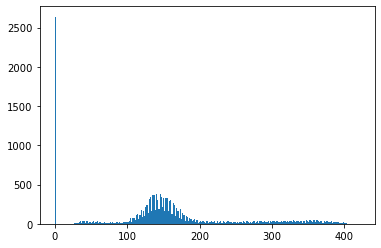

In [456]:
plt.hist(ori_mods[0][2][:,:,10].ravel(), 256)

(array([[128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        [128.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 50.,   4.,  10., ...,   0.,   0.,   0.],
        [ 63.,   7.,   5., ...,   0.,   0.,   0.],
        [ 74.,   2.,   7., ...,   0.,   0.,   0.]]),
 array([  0. ,  41.6,  83.2, 124.8, 166.4, 208. , 249.6, 291.2, 332.8,
        374.4, 416. ], dtype=float32),
 <a list of 128 BarContainer objects>)

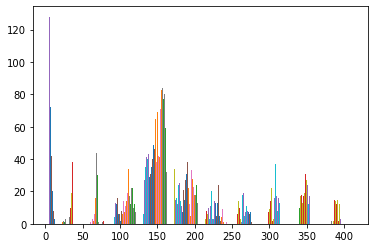

In [362]:
pat8_dl = BRATSDataLoader(
    [patients_train[0]],
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=in_channels
)
batch_ori = next(pat8_dl)
ori_mods = np.moveaxis(batch_ori["data"],2,-1)
plt.hist(ori_mods[0][i][:,:,5])

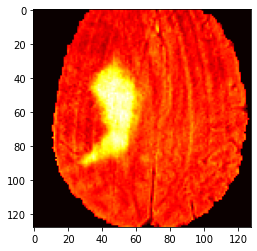

In [482]:
plt.imshow(ori_mods[0][i][:,:,20],cmap="hot")

In [524]:
spatial_transform = copy.deepcopy(ori_mods)
spatial_seg = copy.deepcopy(batch_ori["seg"])

some_return = augment_spatial_2(spatial_transform, spatial_seg, patch_size=patch_size,
                                    patch_center_dist_from_border=[i // 2 for i in patch_size],
                                    do_elastic_deform=True, deformation_scale=(0, 0.25),
                                    do_rotation=True, angle_x=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi), 
                                    angle_y=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
                                    angle_z=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi), 
                                    do_scale=True, scale=(0.75, 1.25),
                                    border_mode_data="constant",
                                    border_cval_data=0, order_data=3,
                                    border_mode_seg="constant", border_cval_seg=0,
                                    order_seg=1, random_crop=True,
                                    p_el_per_sample=1, p_scale_per_sample=1,
                                    p_rot_per_sample=1)

In [533]:
some_return.shape

AttributeError: 'tuple' object has no attribute 'shape'

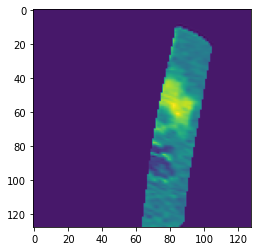

In [543]:
new_thing = np.moveaxis(some_return[0], 2, -1)
plt.imshow(new_thing[0][i][:,:,20])

In [563]:
ori_mods.shape

(12, 3, 128, 128, 24)

In [584]:
spatial_transform = copy.deepcopy(ori_mods)
mirror_mods = copy.deepcopy(ori_mods)
brightness_multiplicative = copy.deepcopy(ori_mods)
gamma_transform = copy.deepcopy(ori_mods)
gaussian_noise = copy.deepcopy(ori_mods)
gaussian_blur = copy.deepcopy(ori_mods)

mirror_mods = augment_mirroring(mirror_mods[0])[0]
brightness_multiplicative = augment_brightness_multiplicative(brightness_multiplicative[0], (0.5,0.9))
gamma_transform = augment_gamma(gamma_transform[0], (0.5,0.9))
gaussian_noise = augment_gaussian_noise(gaussian_noise[0], (0,0.05))
gaussian_blur = augment_gaussian_blur(gaussian_blur[0], (0.5,1.5))

In [571]:



spatial_transform = copy.deepcopy(ori_mods)

spatial_transform, seg_result = augment_spatial_2(spatial_transform, spatial_seg, patch_size=patch_size,
                                    patch_center_dist_from_border=[i // 2 for i in patch_size],
                                    do_elastic_deform=True, deformation_scale=(0, 0.25),
                                    do_rotation=True, angle_x=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi), 
                                    angle_y=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi),
                                    angle_z=(- 15 / 360. * 2 * np.pi, 15 / 360. * 2 * np.pi), 
                                    do_scale=True, scale=(0.75, 1.25),
                                    border_mode_data="constant",
                                    border_cval_data=0, order_data=3,
                                    border_mode_seg="constant", border_cval_seg=0,
                                    order_seg=1, random_crop=True,
                                    p_el_per_sample=1, p_scale_per_sample=1,
                                    p_rot_per_sample=1)
print(spatial_transform.shape)

mirror_mods = copy.deepcopy(spatial_transform)
mirror_mods = augment_mirroring(mirror_mods[0])[0]
print(mirror_mods.shape)

brightness_multiplicative = copy.deepcopy(mirror_mods)
brightness_multiplicative = augment_brightness_multiplicative(brightness_multiplicative, (0.5,0.9))
print(brightness_multiplicative.shape)

gamma_transform = copy.deepcopy(brightness_multiplicative)
gamma_transform = augment_gamma(gamma_transform, (0.5,0.9))
print(gamma_transform.shape)

gaussian_noise = copy.deepcopy(gamma_transform)
gaussian_noise = augment_gaussian_noise(gaussian_noise, (0,0.05))
print(gaussian_noise.shape)

gaussian_blur = copy.deepcopy(gaussian_noise)
gaussian_blur = augment_gaussian_blur(gaussian_blur, (0.5,1.5))
print(gaussian_blur.shape)


(12, 3, 24, 128, 128)
(3, 24, 128, 128)
(3, 24, 128, 128)
(3, 24, 128, 128)
(3, 24, 128, 128)
(3, 24, 128, 128)


In [575]:
finals = np.moveaxis(gaussian_blur, 1, -1)
finals.shape

(3, 128, 128, 24)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticks'

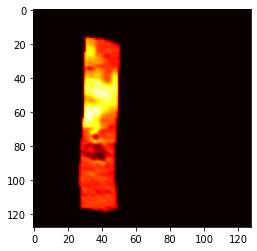

In [582]:
i=2
fig, axs= plt.subplots(1, 6, frameon=False)

# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)

subimage_augs(axs[0], ori_mods[0][i][:,:,20], 'All augmentations', alpha=1.0)
plt.savefig(f"figures/diss_fig/Pat1" ,dpi=450, bbox_inches='tight', pad_inches=0)

fig, axs = plt.subplot(1,1,)
plt.imshow(finals[2][:,:,20],cmap="hot")

    
plt.savefig(f"figures/diss_fig/Patlmaoooooo" ,dpi=450, bbox_inches='tight', pad_inches=0)


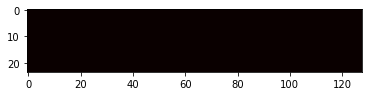

In [579]:
plt.imshow(mirror_mods[i][:,:,20],cmap="hot")

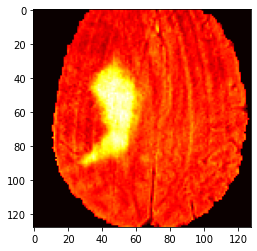

In [558]:
plt.imshow(mirror_mods[i][:,:,20],cmap="hot")

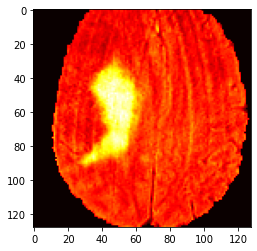

In [485]:
plt.imshow(brightness_multiplicative[i][:,:,20],cmap="hot")

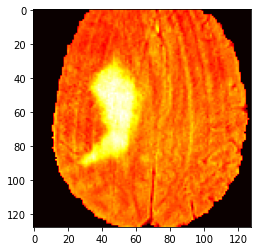

In [493]:
plt.imshow(gamma_transform[i][:,:,20],cmap="hot")

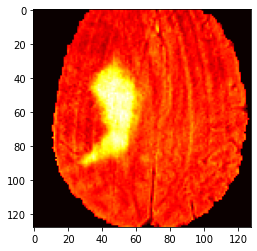

In [486]:
gaussian_noise = copy.deepcopy(ori_mods)
gaussian_noise = augment_gaussian_noise(gaussian_noise[0], (0,0.05))

plt.imshow(gaussian_noise[i][:,:,20],cmap="hot")

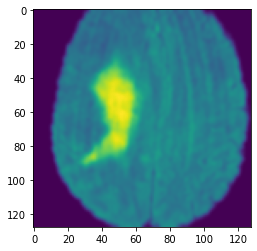

In [434]:
plt.imshow(gaussian_blur[i][:,:,20])

In [19]:
pat8_dl = BRATSDataLoader(
    [patients_train[0]],
    batch_size=batch_size,
    patch_size=patch_size,
    in_channels=in_channels
)
tr_transforms = get_train_transform(patch_size)

tr_gen_pat8 = MultiThreadedAugmenter(pat8_dl, tr_transforms, num_processes=4, # num_processes=4
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)
batch_p8 = next(tr_gen_pat8)
batch_ori = next(pat8_dl)

# t1c_aug = np.moveaxis(batch_p8["data"][1,0,:,:,:],0,-1)
# t2_aug = np.moveaxis(batch_p8["data"][1,1,:,:,:],0,-1)
# flair_aug = np.moveaxis(batch_p8["data"][1,2,:,:,:],0,-1)
# seg_aug = np.moveaxis(batch_p8["seg"][1,0,:,:,:],0,-1)

t1c_aug = np.moveaxis(batch_p8["data"][0][0],0,-1)
t2_aug = np.moveaxis(batch_p8["data"][0][1],0,-1)
flair_aug = np.moveaxis(batch_p8["data"][0][2],0,-1)
seg_aug = np.moveaxis(batch_p8["seg"][0][0],0,-1)

ori_mods = np.moveaxis(batch_ori["data"],2,-1)
seg_ori = np.moveaxis(batch_ori["seg"],2,-1)

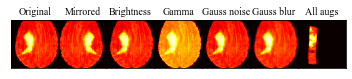

In [585]:
i=2
fig, axs= plt.subplots(1, 7, frameon=False)

# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)

subimage_augs(axs[0], ori_mods[0][i][:,:,20], 'Original', alpha=1.0)
subimage_augs(axs[1], mirror_mods[i][:,:,20], 'Mirrored', alpha=1.0)
subimage_augs(axs[2], brightness_multiplicative[i][:,:,20], 'Brightness', alpha=1.0)
subimage_augs(axs[3], gamma_transform[i][:,:,20], 'Gamma', alpha=1.0)
subimage_augs(axs[4], gaussian_noise[i][:,:,20], 'Gauss noise', alpha=1.0)
subimage_augs(axs[5], gaussian_blur[i][:,:,20], 'Gauss blur', alpha=1.0)
subimage_augs(axs[6], finals[i][:,:,20], 'All augs', alpha=1.0)

plt.savefig(f"figures/diss_fig/Pat1_1" ,dpi=450, bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
t1c_aug.shape

In [ ]:
plt.imshow(patient_t1[:,:,100])

In [ ]:
validation_data_path = f'{path_to_this_repo_folder}MICCAI_BraTS2020_ValidationData/'
training_data_path = f'{path_to_this_repo_folder}MICCAI_BraTS2020_TrainingData/'

patient_list = [i for i in os.listdir(training_data_path) if i != "survival_evaluation.csv"]

for patient_name in patient_list:
    print(f"Patient name: {patient_name}")
    patient_t1 = nib.load(training_data_path + f'{patient_name}/' +  f'{patient_name}_t1.nii.gz').get_fdata()
    patient_t1c = nib.load(training_data_path + f'{patient_name}/' +  f'{patient_name}_t1ce.nii.gz').get_fdata()
    patient_t2 = nib.load(training_data_path + f'{patient_name}/' +  f'{patient_name}_t2.nii.gz').get_fdata()
    patient_flair = nib.load(training_data_path + f'{patient_name}/' +  f'{patient_name}_flair.nii.gz').get_fdata()
    patient_seg = nib.load(training_data_path+ f'{patient_name}/' + f"{patient_name}_seg.nii.gz").get_fdata()

    fig, axs = plt.subplots(1, 5, frameon=False)
    slice_nr = 65
    print(patient_seg.nonzero())
    # Remove horizontal space between axes
    fig.subplots_adjust(wspace=0)

    subimage(axs[0], patient_t1[:,:,slice_nr], '(a) T1', alpha=1.0)

    subimage(axs[1], patient_t1c[:,:,slice_nr], '(b) T1c', alpha=1.0)

    subimage(axs[2], patient_t2[:,:,slice_nr], '(c) T2', alpha=1.0)

    subimage(axs[3], patient_flair[:,:,slice_nr], '(d) FLAIR', alpha=1.0)

    subimage(axs[4], patient_t1[:,:,slice_nr], 'T1', alpha=1.0)
    subimage(axs[4], patient_seg[:,:,slice_nr], '(e) GT.', alpha=0.8)
    
    plt.savefig(f'figures/Training/{patient_name}.jpg', dpi=400, bbox_inches='tight', pad_inches=0)

    plt.show()


In [ ]:
slice_num = 16

fig, axs = plt.subplots(1, 3, frameon=False)
axs[0].set_title("T1ce")
axs[1].set_title("T2")
axs[2].set_title("FLAIR")

axs[0].imshow(t1c_aug[:,:,slice_num])
axs[1].imshow(t2_aug[:,:,slice_num])
axs[2].imshow(flair_aug[:,:,slice_num])

In [ ]:
original_shape = metadata_first['original_shape']
seg_original_shape = np.zeros(original_shape, dtype=np.uint8)
nonzero = metadata_first['nonzero_region']
seg_original_shape[nonzero[0, 0] : nonzero[0, 1] + 1,
           nonzero[1, 0]: nonzero[1, 1] + 1,
           nonzero[2, 0]: nonzero[2, 1] + 1] = t1c_aug

sitk_image = sitk.GetImageFromArray(seg_original_shape)
sitk_image.SetDirection(metadata_first['direction'])
sitk_image.SetOrigin(metadata_first['origin'])

# remember to revert spacing back to sitk order again
sitk_image.SetSpacing(tuple(metadata_first['spacing'][[2, 1, 0]]))
# logging.info(output_file)
sitk.WriteImage(sitk_image, "t1c_aug")

In [ ]:
nib.save(t1c_aug, "t1c_augmented")

In [ ]:
fig, axs = plt.subplots(1, 4, frameon=False)
slice_nr = 20

# Remove horizontal space between axes
fig.subplots_adjust(wspace=0)

subimage(axs[0], t1c_aug[:,:,slice_nr], '(a) T1c', alpha=1.0)

subimage(axs[1], t2_aug[:,:,slice_nr], '(b) T2', alpha=1.0)

subimage(axs[2], flair_aug[:,:,slice_nr], '(c) FLAIR', alpha=1.0)

subimage(axs[3], seg_aug[:,:,slice_nr], '(c) seg', alpha=1.0)


plt.show()

In [ ]:
patdata, metadata = BRATSDataLoader.load_patient(target_patients[0])

In [ ]:
metadata

In [ ]:
meta_data

In [ ]:
from tqdm import tqdm
tr_transforms = get_train_transform(patch_size)

for patient in tqdm(target_patients):
    
    original_size, metadata_old = BRATSDataLoader.load_patient(patient)
    patch_size = list(original_size[0,:,:,:].shape)
    print(f"Patch size is: {patch_size}")
    
    name = patient.split("\\")[-1]
    print(f"Patient {name}")
    
    test_dl_new = BRATSDataLoader(
    [patient],
    batch_size=1,
    patch_size=patch_size,
    in_channels=in_channels
    ) 

    # What if we apply the same process to the test data first? 
    test_gen_new =  MultiThreadedAugmenter(test_dl_new, tr_transforms, num_processes=4, # num_processes=4
                                    num_cached_per_queue=3,
                                    seeds=None, pin_memory=False)

#     test_gen_new.restart()
    batch = next(test_gen_new)
    patient_data = batch["data"]
    meta_data = batch["metadata"][0]
    name = batch["names"]
    print(name, patient_data.shape)
    
    test_gen_new._finish()
    del test_dl_new
    continue

In [ ]:
patient_data.shape

In [ ]:
batch["metadata"][0]

In [ ]:
test_dl_new = BRATSDataLoader(
target_patients,
batch_size=1,
patch_size=patch_size,
in_channels=in_channels
) 

# What if we apply the same process to the test data first? 
test_gen_new =  MultiThreadedAugmenter(test_dl_new, tr_transforms, num_processes=4, # num_processes=4
                                num_cached_per_queue=3,
                                seeds=None, pin_memory=False)

for patient in range(len(target_patients)):
#     name = patient.split("\\")[-1]
#     print(f"Patient {name}")

    batch = next(test_gen_new)
    patient_data = batch["data"]
    meta_data = batch["metadata"]
    name = batch["names"]
    print(name, patient_data.shape)

    continue

In [ ]:
stringlol = "brats_data_preprocessed/Brats20ValidationData/BraTS20_Validation_001"

stringlol.split('/')[-1]

In [ ]:
target_patients

In [ ]:
next(test_gen)['data'].shape

In [ ]:
test_gen2 = SingleThreadedAugmenter()

In [ ]:
for idx, batch in enumerate(test_gen):
    print(idx,batch["names"])

In [ ]:
batch.keys()

In [ ]:
for idx, i in enumerate(test_gen):
    print(i)

In [ ]:
batch = next(test_dl)

In [ ]:
batch = next(tr_gen)
batch["data"][0].shape

In [ ]:
batch = next(tr_gen)
batch["data"][0].shape

In [ ]:
some_pat = batch["data"][0][0]
some_pat = np.moveaxis(some_pat, 0, -1)
print(some_pat.shape)

In [ ]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [ ]:
slice_0 = some_pat[65, :, :]
slice_1 = some_pat[:, 65, :]
slice_2 = some_pat[:, :, 5]

show_slices([slice_0,slice_1,slice_2])


In [ ]:
slice_0 = some_pat[65, :, :]
slice_1 = some_pat[:, 65, :]
slice_2 = some_pat[:, :, 15]

show_slices([slice_0,slice_1,slice_2])


In [ ]:
train_dl.generate_train_batch()["data"].shape

In [ ]:
next(iterate_through_patients(target_patients, in_channels))[0].shape

In [ ]:
import nibabel as nib

nib.load("MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz").get_fdata().shape

In [ ]:
data , metadata = BRATSDataLoader.load_patient(base+"Brats20TrainingData/BraTS20_Training_001")
data.shape

In [ ]:
data , metadata = BRATSDataLoader.load_patient(base+"Brats20ValidationData/BraTS20_Validation_001")
data.shape

In [ ]:
pad_nd_image(data, [144, 192, 192]).shape